# Example Q1 - Qubit rotation

This notebook demonstrates PennyLane's "Hello world!" example for qubit-based architectures, using the default qubit backend. 

The task is to optimize two rotation gates in order to flip a single qubit from state $|0\rangle$ to state $|1\rangle $. 

## Imports

First we need to import PennyLane, as well as PennyLane's wrapped version of NumPy. This allows us to automatically compute gradients for functions that manipulate NumPy arrays, including quantum functions. We will compare two optimizers, basic gradient descent and adagrad.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer, AdagradOptimizer

Next, we instantiate the default simulator as a "device" to run the quantum node. We only need a single quantum wire.

In [2]:
dev = qml.device('default.qubit', wires=1)

## Quantum node

We define a quantum node which encapsulates the function `circuit`. 

The decorator `qml.qnode(dev)` automatically converts from the python function `circuit` to a quantum node object, which is evaluated on the specified device. Quantum nodes can be equivalently created with `circuit = qml.qnode.QNode(circuit, dev)`. 

In [3]:
@qml.qnode(dev)
def circuit(var):

    qml.RX(var[0], wires=0)
    qml.RY(var[1], wires=0)
    
    return qml.expval(qml.PauliZ(0))

This function uses PennyLane to run the following quantum circuit:

<img src="figures/rotation_circuit.png">

Starting with a qubit in the ground state, 

$$ |0\rangle = \begin{pmatrix}1 \\ 0 \end{pmatrix}, $$

we first rotate the qubit around the x-axis by 
$$R_x(v_1) = e^{-iv_1 X /2} = 
\begin{pmatrix} \cos \frac{v_1}{2} &  -i \sin \frac{v_1}{2} \\  
                -i \sin \frac{v_1}{2} &  \cos \frac{v_1}{2} 
\end{pmatrix}, $$ 
               
and then around the y-axis by 
$$ R_y(v_2) = e^{-i v_2 Y/2} = 
\begin{pmatrix} \cos \frac{v_2}{2} &  - \sin \frac{v_2}{2} \\  
                \sin \frac{v_2}{2} &  \cos \frac{v_2}{2} 
\end{pmatrix}. $$ 

After these operations the qubit is in the final state

$$ | \psi \rangle = R_y(v_1) R_x(v_2) | 0 \rangle. $$

Finally, we measure the expectation $ \langle \psi | Z | \psi \rangle $ of the Pauli-Z operator 
$$Z = 
\begin{pmatrix} 1 &  0 \\  
                0 & -1 
\end{pmatrix}. $$ 


Depending on the circuit parameters $v_1$ and $v_2$, the output expectation lies between $1$ (if $| \psi \rangle = | 0  \rangle $) and $-1$ (if $| \psi \rangle = | 1  \rangle $).

## Objective

Next, we define a cost. Here, the function we wish to optimize is directly the expectation of the PauliZ measurement, so that the cost is trivially the output of the circuit.

In [4]:
def objective(var):
    return circuit(var)

With this objective, the optimization procedure is tasked with finding the weights that rotate the qubit from the ground state 

 <img src="figures/bloch_before.png" width="250"> 
 
 to the excited state
 
 <img src="figures/bloch_after.png" width="250">

The rotation gates give the optimization landscape a trigonometric shape with four global minima and five global maxima within the domain $[-2\pi, 2\pi] \times [-2\pi, 2\pi]$. 
 
*Note: To run the following cell you need the matplotlib library.*

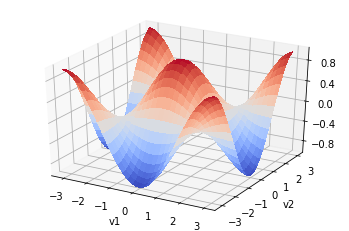

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
%matplotlib inline

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 3.1, 0.1)
Y = np.arange(-3.1, 3.1, 0.1)
length = len(X)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(length, length)
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.show()

## Optimization

The initial values of the x- and y-rotation parameters $v_1, v_2$ are set to near-zero. This corresponds approximately to identity gates; in other words, the circuit leaves the qubit near the ground state.

In [6]:
var_init = np.array([-0.011, -0.012])

The value of the objective at the initial point is close to $1$.

In [7]:
objective(var_init)

0.9998675058299387

We choose a simple GradientDescentOptimizer and update the weights for 10 steps. The final parameters correspond to a $Z$ expectation of nearly $-1$, which means that the qubit is flipped.

In [8]:
gd = GradientDescentOptimizer(0.4)


var = var_init
var_gd = [var]

for it in range(100):
    var = gd.step(objective, var)

    if (it + 1) % 5 == 0:
        var_gd.append(var)
        print('Objective after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, objective(var), var) )

Objective after step     5:  0.9961778 | Angles: [-0.05911537 -0.0644936 ]
Objective after step    10:  0.8974944 | Angles: [-0.31109663 -0.34002089]
Objective after step    15:  0.1440490 | Angles: [-1.09530423 -1.25068588]
Objective after step    20: -0.1536720 | Angles: [-1.1317852 -1.9407188]
Objective after step    25: -0.9152496 | Angles: [-0.29269523 -2.84352066]
Objective after step    30: -0.9994046 | Angles: [-0.02419352 -3.11698103]
Objective after step    35: -0.9999964 | Angles: [-1.88206857e-03 -3.13967807e+00]
Objective after step    40: -1.0000000 | Angles: [-1.46350019e-04 -3.14144378e+00]
Objective after step    45: -1.0000000 | Angles: [-1.13801776e-05 -3.14158108e+00]
Objective after step    50: -1.0000000 | Angles: [-8.84922614e-07 -3.14159175e+00]
Objective after step    55: -1.0000000 | Angles: [-6.88115824e-08 -3.14159258e+00]
Objective after step    60: -1.0000000 | Angles: [-5.35078863e-09 -3.14159265e+00]
Objective after step    65: -1.0000000 | Angles: [-4.1

Starting at a different offset, we train another optimizer called Adagrad, which improves on gradient descent.

*Note: Adagrad, as many other optimizers, has internal hyperparameters that are stored in the optimizer instance (here: `ada`). To reset these hyperparameters, use `ada.reset()`.*

In [9]:
ada = AdagradOptimizer(0.4)

var = var_init
var_ada = [var]

for it in range(100):
    var = ada.step(objective, var)
    
    if (it + 1) % 5 == 0:
        var_ada.append(var)
        print('Objective after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, objective(var), var) )

Objective after step     5:  0.0123798 | Angles: [-1.45877111 -1.45982822]
Objective after step    10: -0.0000052 | Angles: [-1.56419732 -1.57158437]
Objective after step    15: -0.0008878 | Angles: [-1.54089864 -1.6004995 ]
Objective after step    20: -0.0535320 | Angles: [-1.33713923 -1.80411042]
Objective after step    25: -0.7042678 | Angles: [-0.57448842 -2.56613427]
Objective after step    30: -0.9855194 | Angles: [-0.12029953 -3.02063734]
Objective after step    35: -0.9994782 | Angles: [-0.02272916 -3.11863269]
Objective after step    40: -0.9999814 | Angles: [-0.00427525 -3.13725339]
Objective after step    45: -0.9999993 | Angles: [-8.04023945e-04 -3.14077269e+00]
Objective after step    50: -1.0000000 | Angles: [-1.51207827e-04 -3.14143771e+00]
Objective after step    55: -1.0000000 | Angles: [-2.84367179e-05 -3.14156338e+00]
Objective after step    60: -1.0000000 | Angles: [-5.34791708e-06 -3.14158712e+00]
Objective after step    65: -1.0000000 | Angles: [-1.00574958e-06 -3

Adagrad and gradient descent find the same minimum, and, since neither has information on second order derivatives, both take a detour through a saddle point. However, while Adagrad reaches the saddle point very quickly and then spends considerable time there, gradient descent bypasses it and reaches the minimum quicker. This behaviour is of course strongly dependent on the learning rate. 

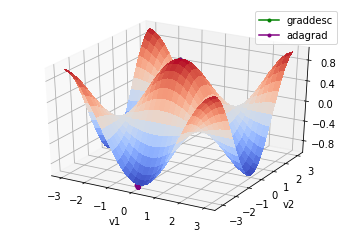

In [10]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, 3, 30)
Y = np.linspace(-3, 3, 30)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(var)+1e-8 for var in var_ada]
path_x = [v[0] for v in var_ada]
path_y = [v[1] for v in var_ada]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="adagrad")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

### Choosing initial variables

The variables are best randomly initialized with near-zero values. To show why constant initializations can go wrong, consider starting at exactly zero. 

In [11]:
var = np.array([0., 0.])

for it in range(10):
    var = gd.step(objective, var)
    print('Objective after step {:5d}: {: .7f}'.format(it + 1, objective(var)) )

Objective after step     1:  1.0000000
Objective after step     2:  1.0000000
Objective after step     3:  1.0000000
Objective after step     4:  1.0000000
Objective after step     5:  1.0000000
Objective after step     6:  1.0000000
Objective after step     7:  1.0000000
Objective after step     8:  1.0000000
Objective after step     9:  1.0000000
Objective after step    10:  1.0000000


In this case, the model is "stuck" in the maximum of the cost function, where the gradient vanishes.